In [ ]:
import rasterio
import numpy as np

In [2]:
input_sar_image_path  = "../../SAR_Data_processing_eaton/8_subset/eaton_S1A_IW_GRDH_1SDV_stack_32611_clip_bilinear_10m.tif"
input_label_image_path="input/eaton_dnbr_label.tif"

In [3]:
# Load input image (tif)
with rasterio.open(input_sar_image_path) as src:
    input_image = src.read([1, 2, 3,4])  # Read all RGB bands (assuming 3 bands)
    input_image = np.moveaxis(input_image, 0, -1)  # Shape: (height, width, channels)

# Load label image (tif)
with rasterio.open(input_label_image_path) as src:
    label_image = src.read(1)  # Assuming the label is a single band

In [4]:
patch_size = 64  # Size of each patch (64x64 pixels)
stride = 32  # Stride for moving the patch across the image

def extract_patches(image, label, patch_size, stride):
    patches = []
    label_patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size, stride):
        for x in range(0, width - patch_size, stride):
            patch = image[y:y + patch_size, x:x + patch_size, :]
            label_patch = label[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            label_patches.append(label_patch)
    return np.array(patches), np.array(label_patches)

# Extract patches from both input image and label image
X_patches, y_patches = extract_patches(input_image, label_image, patch_size, stride)

print(X_patches.shape)


(2014, 64, 64, 4)


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_patches, y_patches, test_size=0.50, random_state=42)
# Split the remaining data into validation and testing sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

y_train = np.expand_dims(y_train, axis=-1)
y_val=np.expand_dims(y_val, axis=-1)
y_test=np.expand_dims(y_test, axis=-1)
print(f"Train data: {X_train.shape}")
print(f"train label data: {y_train.shape}")

print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")


Train data: (1007, 64, 64, 4)
train label data: (1007, 64, 64, 1)
Validation data: (402, 64, 64, 4)
Test data: (605, 64, 64, 4)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout

# Create a CNN model for segmentation (pixel-wise binary classification)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 4)),  # Input shape (64, 64, 4)
    MaxPooling2D((2, 2)),  # Pooling layer reduces size from 64x64 to 32x32
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Pooling layer reduces size from 32x32 to 16x16
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Pooling layer reduces size from 16x16 to 8x8
    
    # Upsampling to increase spatial resolution
    UpSampling2D((2, 2)),  # Increases size from 8x8 to 16x16
    Conv2D(64, (3, 3), activation='relu'),
    UpSampling2D((2, 2)),  # Increases size from 16x16 to 32x32
    Conv2D(32, (3, 3), activation='relu'),
    UpSampling2D((2, 2)),  # Increases size from 32x32 to 64x64
    Conv2D(32, (5, 5), activation='relu'),
    UpSampling2D((2, 2)),  
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'), # Final output layer (64x64x1)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,713 (827.00 KB)

 Trainable params: 211,713 (827.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.7449 - loss: 0.6418 - val_accuracy: 0.8368 - val_loss: 0.3992
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8566 - loss: 0.3701 - val_accuracy: 0.8827 - val_loss: 0.3292
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8348 - loss: 0.4350 - val_accuracy: 0.8601 - val_loss: 0.3667
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8780 - loss: 0.3305 - val_accuracy: 0.8876 - val_loss: 0.3246
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8825 - loss: 0.3120 - val_accuracy: 0.8801 - val_loss: 0.3285
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8858 - loss: 0.3132 - val_accuracy: 0.8977 - val_loss: 0.2869
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9000 - loss: 0.2793 - val_accuracy: 0.8996 - val_loss: 0.2768
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9150 - loss: 0.2446 - val_accuracy: 0.9147 - v

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9265 - loss: 0.2176
Test Accuracy: 0.9252021908760071


In [9]:
import numpy as np
from tensorflow.image import extract_patches

def extract_image_patches(image, patch_size=(64, 64), stride=64):
    """
    Extracts patches from an image.
    
    Args:
    - image (numpy array): Input image of shape (H, W, C)
    - patch_size (tuple): Size of each patch (height, width)
    - stride (int): Step size for moving window
    
    Returns:
    - patches (numpy array): Extracted patches (num_patches, patch_size, patch_size, C)
    """
    H, W, C = image.shape
    patch_H, patch_W = patch_size

    # Compute number of patches
    num_patches_H = (H - patch_H) // stride + 1
    num_patches_W = (W - patch_W) // stride + 1

    patches = []

    for i in range(0, H - patch_H + 1, stride):
        for j in range(0, W - patch_W + 1, stride):
            patch = image[i:i + patch_H, j:j + patch_W, :]
            patches.append(patch)

    return np.array(patches)



In [10]:
X_patches = extract_image_patches(input_image, patch_size=(64, 64), stride=32)

print("Extracted X_patches shape:", X_patches.shape)

Extracted X_patches shape: (2014, 64, 64, 4)


In [11]:
# X_train, X_temp, y_train, y_temp = train_test_split(X_patches, y_patches, test_size=0.1, random_state=42)
# y_train = np.expand_dims(y_train, axis=-1)
# X_train.shape

In [12]:
# Predict on new data (e.g., test set or validation set)
predictions = model.predict(X_patches)
binary_predictions = (predictions > 0.5).astype(np.uint8)
# class_predictions = np.argmax(binary_predictions, axis=-1)  # Shape: (1409, 64, 64)
print(binary_predictions.shape)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
(2014, 64, 64, 1)


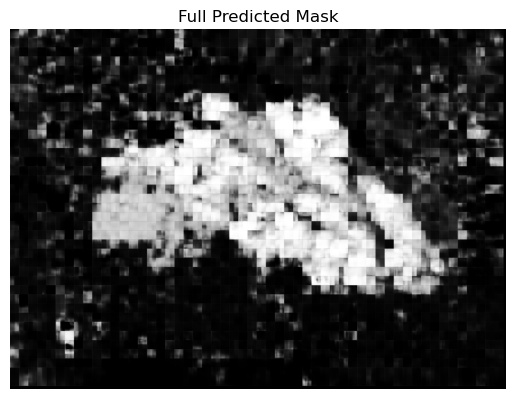

In [13]:
import matplotlib.pyplot as plt
def reconstruct_from_patches(patches, image_size, patch_size=(64, 64), stride=32):
    """
    Reconstructs an image from patches.
    
    Args:
    - patches (numpy array): Predicted patches (num_patches, H, W, C)
    - image_size (tuple): Original image size (H, W)
    - patch_size (tuple): Patch size (H, W)
    - stride (int): Step size used for patch extraction

    Returns:
    - full_image (numpy array): Reconstructed full image
    """
    H, W = image_size
    patch_H, patch_W = patch_size
    full_image = np.zeros((H, W, 1))  # Assuming single-channel output

    idx = 0
    for i in range(0, H - patch_H + 1, stride):
        for j in range(0, W - patch_W + 1, stride):
            full_image[i:i + patch_H, j:j + patch_W, :] = patches[idx]
            idx += 1

    return full_image

# Reconstruct full predicted mask
predicted_mask = reconstruct_from_patches(predictions, input_image.shape[:2])

# Visualize the final prediction
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Full Predicted Mask')
plt.axis('off')
plt.show()
